# 환율 시계열 예측
시간에 따라 원화에 대한 달러화의 환율이 위안화 환율에 미치는 영향

주말에는 ? : https://www.krm.or.kr/krmts/search/detailview/research.html?dbGubun=SD&m201_id=10037284

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import os
import matplotlib.pyplot as plt

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from xgboost import XGBRegressor


In [2]:
def shownull(df):
    global missval_name
    print(f"데이터셋 차원 확인 \n {df.shape}")
    missval = df.isnull().sum()[df.isnull().sum()!=0]
    print(f"결측값 있는 변수 확인 \n {missval}")
    missval_name = missval.index # <- 결측치가 존재하는 열이 저장된 변수임

def RMSE(t, p) :
    return np.sqrt(mean_squared_error(t, p))

In [3]:
df = pd.read_csv("./Data/환율/기획재정부_환율_20230208.csv", encoding='CP949')
df.set_index('일자(년월일)', inplace=True)

In [4]:
df

,달러(원),위안(원)
일자(년월일),,
2021-09-01,1157.2,179.20
2021-09-02,1161.5,179.90
2021-09-03,1157.0,179.30
2021-09-06,1156.5,179.40
2021-09-07,1157.8,179.40
...,...,...
2023-02-01,1231.3,182.39
2023-02-02,1220.3,181.74
2023-02-03,1229.4,182.13


XGB, CNN(1차원), LSTM, ARiMA 해보기

# 전처리

In [5]:
shownull(df)

데이터셋 차원 확인 
 (353, 2)
결측값 있는 변수 확인 
 Series([], dtype: int64)


In [6]:
df_USD = pd.DataFrame(df.iloc[:,0])
df_CNY = pd.DataFrame(df.iloc[:,1])

In [7]:
scaler = MinMaxScaler()
test_point = '2022-11-07'
val_point = '2022-08-07'

def split_ts(x_data, y_data):
    global X_train, X_test, X_val, y_train, y_test, y_val

    x_train0, X_test = x_data[x_data.index < test_point], x_data[x_data.index >= test_point]
    y_train0, y_test = y_data[y_data.index < test_point], y_data[y_data.index >= test_point]

    X_train, X_val = x_train0[x_train0.index < val_point], x_train0[x_train0.index >= val_point]
    y_train, y_val = y_train0[y_train0.index < val_point], y_train0[y_train0.index >= val_point]

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)

#Data Leakage를 피하기 위해 분할 후 Scaling
    

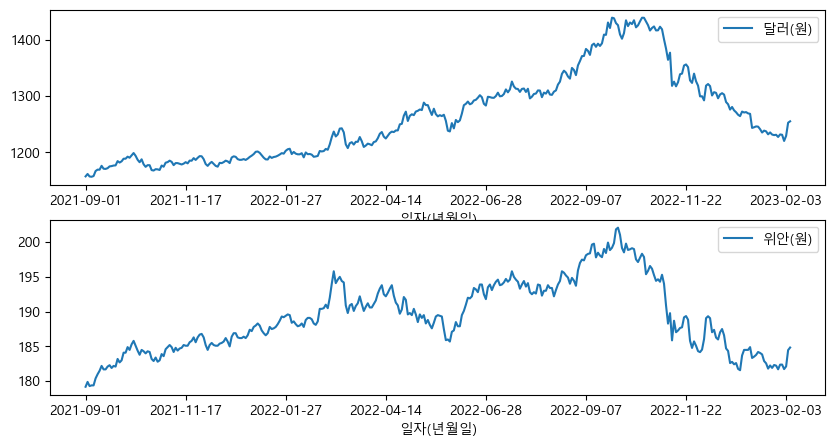

In [10]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = [10,5]
f, (ax1, ax2) = plt.subplots(2,1)
plt.subplots_adjust(wspace=0.25)

df_USD.plot(ax=ax1)

df_CNY.plot(ax=ax2)

plt.show()

# 학습

In [11]:
split_ts(df_USD, df_CNY)

## XGBoost Regressor

In [12]:
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]

SEED = 2023

space={'max_depth': hp.quniform("max_depth", 5, 15, 1),
       'learning_rate': hp.quniform ('learning_rate', 0.01, 0.05, 0.005),
       'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
       'n_estimators': hp.quniform('n_estimators', 200, 1000, 100)
      }

#학습을 위한 목적 변수 설정
def xgb_hptuning(space) :
    xgb_model = XGBRegressor(n_estimators =int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    learning_rate = space['learning_rate'],
                    subsample = space['subsample'],
                    min_child_weight = int(space['min_child_weight']),
                    early_stopping_rounds=20,
                    random_state=SEED,
                    eval_metric='rmse'
    )
    evaluation = [(X_train, y_train), (X_val, y_val)]
    
    xgb_model.fit(X_train, y_train,
              eval_set=evaluation,
              verbose=0)

    pred = xgb_model.predict(X_val)
    rmse= RMSE(y_val, pred)

    # 평가 방식 선정
    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_model}

In [13]:
# Trials
trials = Trials()

best = fmin(fn=xgb_hptuning,
            space=space,
            algo=tpe.suggest,
            max_evals=10, # 최대 반복 횟수를 지정합니다.
            trials=trials)

best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])
best['n_estimators'] = int(best['n_estimators'])
best['random_state'] = SEED

print(best)

100%|██████████| 10/10 [00:02<00:00,  4.06trial/s, best loss: 2.507178482164542]
{'learning_rate': 0.04, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 900, 'subsample': 0.9500000000000001, 'random_state': 2023}


In [14]:
xgb = XGBRegressor(**best)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [15]:
print(RMSE(y_test, y_pred))
print(xgb.score(y_test, y_pred)) #음수 : 과적합 발생

8.432961707319341
-0.9159922951163988


In [16]:
y_val.iloc[-1,:].name

'2022-11-04'

In [25]:
len(pd.concat([y_train, y_val]).index)

289

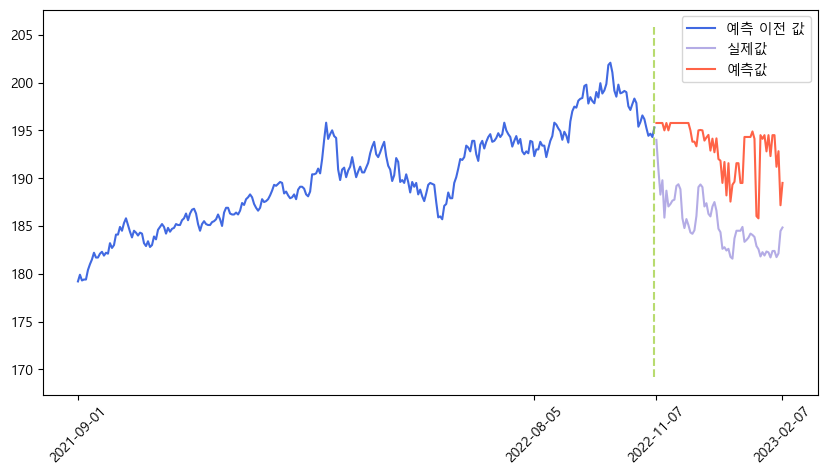

In [43]:
#여기에 그래프

plt.plot(pd.concat([y_train, y_val], axis=0), label = '예측 이전 값', color = 'royalblue')
plt.plot(y_test, label = "실제값", alpha = 0.5 ,color = 'slateblue')
plt.plot(pd.DataFrame(y_pred, index=y_test.index), label = '예측값', color = 'tomato')
plt.vlines(x=(y_val.iloc[-1].name), ymin=y_train.min()-10, ymax=y_train.max()+10, linestyles='dashed', colors='yellowgreen', alpha = 0.7)

x_label = y_train.iloc[[0,-1]].index.to_list() + y_test.iloc[[0, -1]].index.to_list()

#여기에 x ticks 만들것
plt.xticks(x_label, rotation = 45)

plt.legend()
plt.show()

## LSTM

https://wikidocs.net/173005 </p>
https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

In [86]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(10,1))) #10개의 이전 날짜(2주치)를 학습하며, 차원은 1개(변수 : 달러환율)
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu', return_sequences=True)) 
#LSTM에 레이어를 하나 더 생성하기 위해서는 이전 레이어에 return_sequences=True를 추가해야함
# 오류 : Input 0 of layer "lstm_" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 10)
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 10, 20)            1760      
                                                                 
 dropout_11 (Dropout)        (None, 10, 20)            0         
                                                                 
 lstm_12 (LSTM)              (None, 10, 20)            3280      
                                                                 
 dropout_12 (Dropout)        (None, 10, 20)            0         
                                                                 
 lstm_13 (LSTM)              (None, 20)                3280      
                                                                 
 dropout_13 (Dropout)        (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [87]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=1000, batch_size=20)
y_pred = model.predict(X_test)

Epoch 1/1000
12/12 [==============================] - 3s 3ms/step - loss: 35519.6289
Epoch 2/1000
12/12 [==============================] - 0s 3ms/step - loss: 35512.4727
Epoch 3/1000
12/12 [==============================] - 0s 3ms/step - loss: 35504.5859
Epoch 4/1000
12/12 [==============================] - 0s 4ms/step - loss: 35495.8242
Epoch 5/1000
12/12 [==============================] - 0s 3ms/step - loss: 35485.0352
Epoch 6/1000
12/12 [==============================] - 0s 3ms/step - loss: 35471.8633
Epoch 7/1000
12/12 [==============================] - 0s 3ms/step - loss: 35455.2344
Epoch 8/1000
12/12 [==============================] - 0s 3ms/step - loss: 35432.8828
Epoch 9/1000
12/12 [==============================] - 0s 3ms/step - loss: 35399.1016
Epoch 10/1000
12/12 [==============================] - 0s 3ms/step - loss: 35349.3555
Epoch 11/1000
12/12 [==============================] - 0s 3ms/step - loss: 35269.7578
Epoch 12/1000
12/12 [==============================] - 0s 3ms/s

In [88]:
print(RMSE(y_test, y_pred))

4.4180057806237665


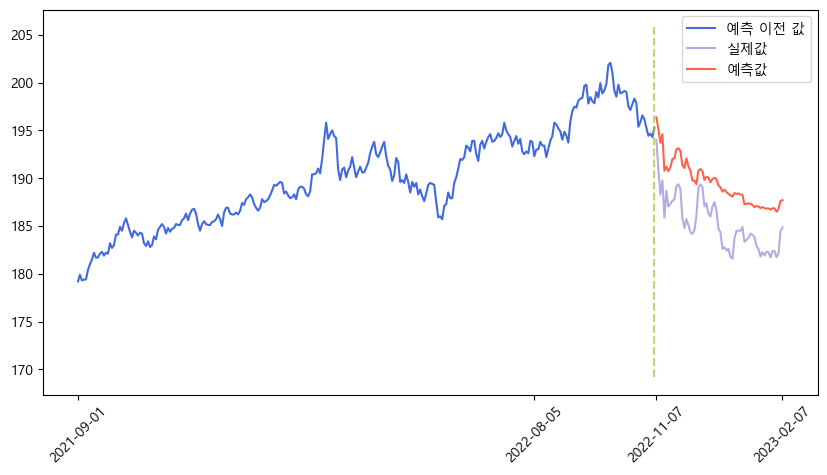

In [89]:
#여기에 그래프

plt.plot(pd.concat([y_train, y_val], axis=0), label = '예측 이전 값', color = 'royalblue')
plt.plot(y_test, label = "실제값", alpha = 0.5 ,color = 'slateblue')
plt.plot(pd.DataFrame(y_pred, index=y_test.index), label = '예측값', color = 'tomato')
plt.vlines(x=(y_val.iloc[-1].name), ymin=y_train.min()-10, ymax=y_train.max()+10, linestyles='dashed', colors='yellowgreen', alpha = 0.7)

x_label = y_train.iloc[[0,-1]].index.to_list() + y_test.iloc[[0, -1]].index.to_list()

#여기에 x ticks 만들것
plt.xticks(x_label, rotation = 45)

plt.legend()
plt.show()